With Constant Step Size

Number of Iterations to achieve a Value Function:    50 

Approximately the limit [ 0.08238127  0.15594569  0.15890983  0.04496624  0.07732096  0.36868514
  0.05550229 -0.07199916  0.03663881  0.13792873  0.08721458  0.1585825
  0.04453607  0.16392344  0.11547519  0.10576263  0.11348204  0.17962994
  0.18294142  0.11082668  0.1393294   0.14821467  0.12880985 -0.14803093
 -0.03122382  0.1761522   0.51508381  0.10338937  0.15125583  0.10023381
  0.25247293  0.25696984  0.01409037  0.33831352  0.11779158  0.0494415
  0.04867685  0.17552591  0.20959671  0.10039902  0.02165511  0.16795892
  0.03869337 -0.03926534  0.14203923  0.08800521  0.13982856 -0.24851963
  0.31803091  0.21864625 -0.30248035  0.15680678 -0.11180331  0.05717698
  0.08436093 -0.13480704  0.20329945 -0.0647287   0.24427452  0.10095431
  0.24898987 -0.03503352  0.27377048  0.03863373  0.0747192   0.27485765
  0.14065109  0.18234853  0.25809568  0.27590259  0.15694761  0.32313829] 1.510874017854574


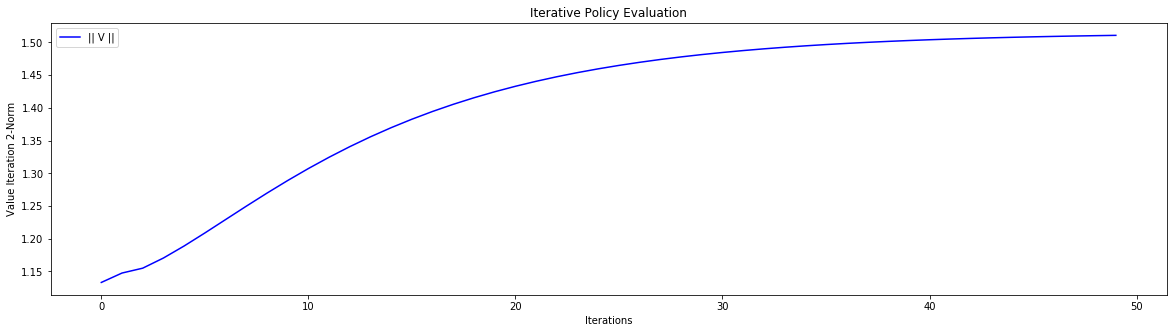

0


<Figure size 1440x360 with 0 Axes>

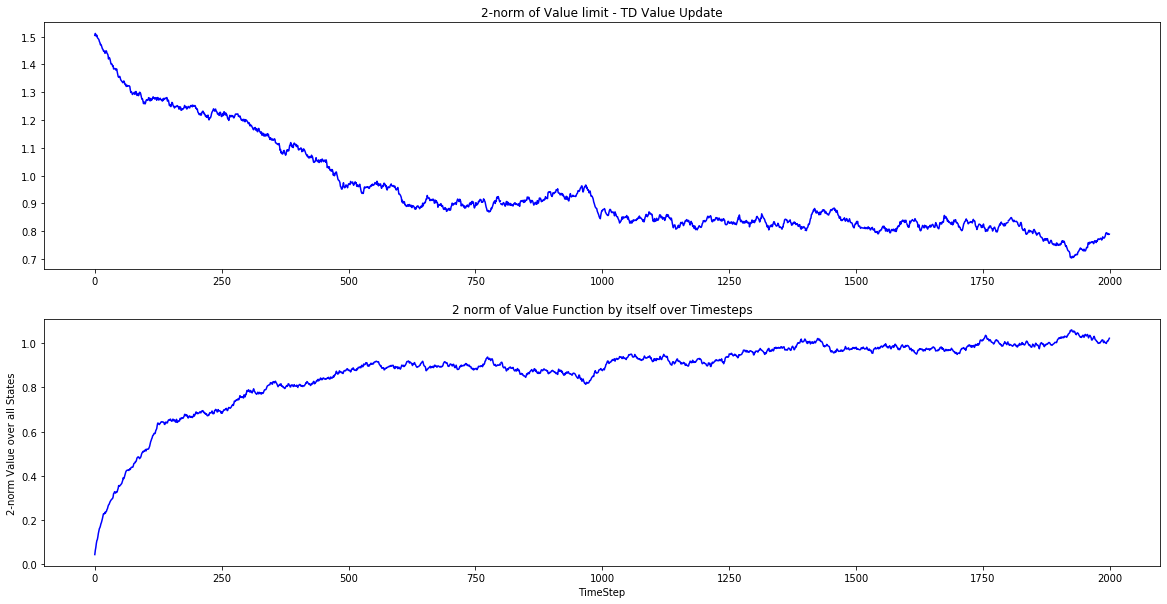

2-norm of Value function after TD Learning:   1.0219807422188034 
 Actual value function vector:   [ 0.09542327  0.17689619  0.11087586  0.03600177  0.04203339  0.24100523
 -0.0080059  -0.09275131  0.0758723   0.13198055 -0.01881417  0.07100535
  0.00876817  0.08651007 -0.04996701  0.0997157   0.16495088  0.08023518
  0.10258575  0.02204555  0.13151862  0.03632562  0.03769676 -0.03204454
  0.04891267  0.0439363   0.17573883  0.11117088  0.09877503  0.03875633
  0.24145678  0.15515247  0.04122007  0.16382259 -0.0171028  -0.00180499
 -0.00452102  0.13880336  0.16618995  0.05703306  0.00312897  0.09929753
  0.02803183 -0.23179563  0.09345755  0.07468744  0.08297518 -0.12536829
  0.17326386  0.15846926 -0.11561829  0.14006192 -0.12129273 -0.06841713
  0.05352795 -0.16620375  0.09873676 -0.04482806  0.15503801  0.0504615
  0.22743264  0.00879552  0.18684723  0.01353782  0.0837568   0.13700415
  0.17459712  0.10845072  0.27131518  0.26697211  0.04085658  0.09128204] 



In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox.example
import random
import math


class TDLearner:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, policy, states, actions, alpha=0.01, gamma=0.95, beta = 0.5, diminish = None, theta = 0.0001):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.value_function = np.zeros(states)

        #discount rate between [0,1]
        self.gamma = gamma

        #step size between [0,1]
        self.alpha = alpha

        #the mapping of states to actions
        self.policy = policy

        self.states = states
        self.actions = actions

        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        #self.rewardMatrix = np.ones((self.actions,self.states,self.states))

        self.probabilityMatrix = np.zeros((self.states,self.states))
        
        self.diminish = diminish
        self.step_size = self.alpha
        self.beta = beta
        
        #theta value for value iteration must be a small positive number
        self.theta = theta
        
        #the value function that will be used for value iteration to find the value function limit
        self.V = np.zeros(self.states)
        self.optimal_policy = {}
        
    def createProbabilityMatrix(self):
        """
        Create the transition probability matrix based on the Policy pi 
        P(s1,s2) = sum a( P(s1,s2)*pi(a|s) )
        """
        
        for s in range(self.states):
            probabilities = np.zeros(self.states)
            for a in range(self.actions):
                    action_prob = self.policy[a]
                    probabilities += self.transitionProbabilities[a][s]*action_prob
            self.probabilityMatrix[s] = probabilities
            

    def getNextState(self, state):
        
        """
        Using the transition probability matrix we created find the next state the agent is going to
        """    
        next_state = np.random.choice(np.arange(0,self.states),1,p = self.probabilityMatrix[state])
        return next_state[0]


    def getValue(self,state):
        """
        Just return the value of the state action pair given the current estimate of the environment
        :param state: observation that was previously seen
        :param action: action that was take
        :return: the value of that state action pair
        """

        return self.value_function[state]

    def updateValueFunction(self,state, next_state,reward):
        """
        Update the action value function based on the
        :param state: previous state
        :param action: action taken at state
        :param next_state: next state the agent is planning on going ot
        :param next_action: if agent were at next_state the action the agent is planning on taking
        :param reward: the reward it received at state taking action
        :return: void,will change the q_function in the class

        using the on policy temporal difference formula
        V (S) ← V (S) + α[R + γV (S') − V (S)]
        """
        
        self.value_function[state] = self.getValue(state) + \
                                         self.step_size*(reward + self.gamma*(self.getValue(next_state))-self.getValue(state))


    def getValueVector(self): 
        """
        for the ability to plot the value function getting the values of all the states as a vector
        return: a list of all the values
        """
        
        values = []
        for state, value in self.value_function.items():
            values.append(value)
        return values


    def bellmanUpdate(self,state):
        """
        Carry Out the update for the Value Function
        param: state is the state that the iteration is currently working on
        return: a list of all the values each action calculates
        will be used later to find the policy as well
        """
        
        total = 0
        new_total = 0
        for a in range(self.actions):
            total=0
            for s_prime in range(self.states):
                total+= self.transitionProbabilities[a][state][s_prime]*(self.rewardMatrix[a][state][s_prime]+self.gamma*self.V[s_prime])
            new_total+= self.policy[a]*total
            
        return new_total 
    
    
    def valueIteration(self):
        """
        Perform Value Iteration on the given MDP 
        
        will provide a optimal deterministic policy for this MDP
        will Plot the V(s) function as well 
        """
        
        delta = float("inf")
        iteration = 0
        v_iter = []

        #value iteration
        while(delta > self.theta):
            delta = 0
            for s in range(self.states):
                v = self.V[s]
                #print("before", self.V[s])
                
                
                #bellman update
                self.V[s] = self.bellmanUpdate(s)
                #print("after", self.V[s])
    
                delta = max(delta, abs(self.V[s]-v))
            
            norm = np.linalg.norm(self.V)
            v_iter.append(norm)
            #print(norm)
            iteration+=1
    
                
                
        #Plotting the Difference between the limit of the Value Function and the value function each iteration
        #The Value function limit seems to be a Value Function with a 2-norm approaching around 16
        print("Number of Iterations to achieve a Value Function:   ", iteration,"\n")
        print("Approximately the limit",self.V, np.linalg.norm(self.V))
        plt.figure(figsize = (20,5))
        plt.plot(range(iteration), v_iter, "b-", label = "|| V ||")
        #plt.plot(range(iteration),np.zeros(iteration)+1.52,"r-", label = "|| V* ||")
        plt.xlabel("Iterations")
        plt.ylabel("Value Iteration 2-Norm")
        plt.title("Iterative Policy Evaluation")
        plt.legend()
        plt.show()
        
    def getOptimalPolicy(self):
        return self.optimal_policy
    
    
    
    def runEnvironment(self, episodes, maxtimesteps):
        """
        Will run the OpenGym AI environment set using on policy Temporal Difference Learning

        :param episodes: the number of episodes you would like to make the enviornment play
        :param maxtimesteps:
        :return: void

        """
        
        """
        Value iteration needs to be run before running this function
        Rough Estimate of the Value Function Limit
        [ 0.08238127  0.15594569  0.15890983  0.04496624  0.07732096  0.36868514
          0.05550229 -0.07199916  0.03663881  0.13792873  0.08721458  0.1585825
          0.04453607  0.16392344  0.11547519  0.10576263  0.11348204  0.17962994
          0.18294142  0.11082668  0.1393294   0.14821467  0.12880985 -0.14803093
         -0.03122382  0.1761522   0.51508381  0.10338937  0.15125583  0.10023381
          0.25247293  0.25696984  0.01409037  0.33831352  0.11779158  0.0494415
          0.04867685  0.17552591  0.20959671  0.10039902  0.02165511  0.16795892
          0.03869337 -0.03926534  0.14203923  0.08800521  0.13982856 -0.24851963
          0.31803091  0.21864625 -0.30248035  0.15680678 -0.11180331  0.05717698
          0.08436093 -0.13480704  0.20329945 -0.0647287   0.24427452  0.10095431
          0.24898987 -0.03503352  0.27377048  0.03863373  0.0747192   0.27485765
          0.14065109  0.18234853  0.25809568  0.27590259  0.15694761  0.32313829]
        """
        
        
 
        self.valueIteration()
        
        plt.figure(figsize=(20,5))
        fig,ax = plt.subplots(2, figsize=(20,10))
        #ax[0].figure(figsize=(20,5))
        #create the transition probability matrix given the policy pi
        self.createProbabilityMatrix()
        for i_episode in range(episodes):
            if i_episode%20==0:
                print(i_episode)
            totalReward = 0
            a = []
            pb = []
            for action, prob in self.policy.items():
                a.append(action)
                pb.append(prob)
            bestAction = np.random.choice(a, maxtimesteps, p=pb)
            state = np.random.randint(0,self.states)
            difference = np.zeros(maxtimesteps)
            V = np.zeros(maxtimesteps)

            for t in range(maxtimesteps):
                
                if self.diminish!=None and self.step_size>=0.001 and i_episode>0:
                    self.step_size = self.diminish(self.alpha, i_episode, self.beta)


                action = bestAction[t]
                
                # take the action into course
                

                
                # update the Q function with the new value
                for state in range(self.states):
                    next_state = self.getNextState(state)
                    reward = self.rewardMatrix[action][state][next_state]
                    self.updateValueFunction(state,next_state, reward)
                
                
                #print(state,next_state,reward,action)
                
                # move on to the next state and action pair
                #state = next_state
                #totalReward += reward
                difference[t] = np.linalg.norm(self.V - self.value_function)
                V[t] = np.linalg.norm(self.value_function)
                
                
            ax[0].plot(range(maxtimesteps * i_episode, maxtimesteps * i_episode + maxtimesteps), difference, 'b-')
            ax[1].plot(range(maxtimesteps * i_episode, maxtimesteps * i_episode + maxtimesteps), V, 'b-')
            
        ax[0].set_title("2-norm of Value limit - TD Value Update")
        ax[1].set_title("2 norm of Value Function by itself over Timesteps")
        plt.xlabel("TimeStep")
        plt.ylabel("2-norm Value over all States")
        plt.show()
        print("2-norm of Value function after TD Learning:  ", np.linalg.norm(self.value_function), "\n Actual value function vector:  ", self.value_function, "\n")
        
    
if __name__ == '__main__':

    np.random.seed(0)
    
    print("With Constant Step Size\n")
    learner = TDLearner(policy={0:0.5,1:0.5},states = 72, actions = 2)
    learner.runEnvironment(10,200)
    
    
#     print("With Diminishing Step Size")
#     learner = TDLearner(policy={0:0.5,1:0.5},states = 72, actions = 2, diminish = lambda a,k,b: a/(k**b))
#     learner.runEnvironment(1000,200)

